In [170]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [171]:

def resize_nearest(image,scale):
    """
    Resize an image using nearest-neighbor interpolation.

    Parameters:
        image (numpy.ndarray): Input image.
        scale (float): Scaling factor (e.g., 1/s).

    Returns:
        numpy.ndarray: Resized image.
    """
    # Compute the new dimensions
    new_height = int(image.shape[0] * scale)
    new_width = int(image.shape[1] * scale)
    
    # Resize using nearest-neighbor interpolation
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
    return resized_image

def boxfilter(imSrc, r):

    hei, wid = imSrc.shape
    imDst = np.zeros_like(imSrc)

    # Cumulative sum over the Y axis
    imCum = np.cumsum(imSrc, axis=0)

    # Difference over the Y axis
    imDst[:r+1, :] = imCum[r:2*r+1, :]
    imDst[r+1:hei-r, :] = imCum[2*r+1:hei, :] - imCum[:hei-2*r-1, :]
    imDst[hei-r:, :] = (imCum[hei-1, :][None, :] - imCum[hei-2*r-1:hei-r-1, :])

    # Cumulative sum over the X axis
    imCum = np.cumsum(imDst, axis=1)

    # Difference over the X axis
    imDst[:, :r+1] = imCum[:, r:2*r+1]
    imDst[:, r+1:wid-r] = imCum[:, 2*r+1:wid] - imCum[:, :wid-2*r-1]
    imDst[:, wid-r:] = (imCum[:, wid-1][:, None] - imCum[:, wid-2*r-1:wid-r-1])

    return imDst

def fastGF (I,r,eps,s):

    I_sub = resize_nearest(I,1/s)
    r_sub = max(1, round(r / s))

    (n1,n2) = I.shape

    (hei, wid) = I_sub.shape
    mx = np.ones((hei,wid))
    N = boxfilter(mx,r_sub)
    ########################
    mean_I = boxfilter(I_sub, r_sub) / N
    mean_II = boxfilter(I_sub*I_sub,r_sub) /N 

    cov_Ip = mean_II - mean_I * mean_I

    a   = cov_Ip / (cov_Ip + eps)
    b   = mean_I - a* mean_I
    
    mean_a = boxfilter(a, r_sub) / N
    mean_b = boxfilter(b, r_sub) / N

    mean_a = cv2.resize(mean_a, (n2, n1), interpolation=cv2.INTER_LINEAR)
    mean_b = cv2.resize(mean_b, (n2, n1), interpolation=cv2.INTER_LINEAR)


    q = mean_a * I + mean_b


    return q



def box_filter_alt(image, kernel_size):
    """
    Applies an unnormalized box filter to the given image.
    :param image: Input grayscale or color image (NumPy array)
    :param kernel_size: Size of the box filter kernel (e.g., 3, 5, 7, etc.)
    :return: Filtered image (Sum of pixel values in the window)
    """
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)  # No normalization
    image = image.astype(np.float32)  # Convert image to float32 to prevent overflow
    boxy = cv2.filter2D(image, -1, kernel)  # Keep full precision
    return boxy  # No need to cast to int32, already float32

def compute_integral_image(img_array):
    """Computes the integral image of the given grayscale image array."""
    return np.cumsum(np.cumsum(img_array, axis=0), axis=1)

import numpy as np

def compute_window_sums(image, window_size):
    """
    Computes window sums using an integral image approach.
    
    Parameters:
    image (numpy.ndarray): Input 2D array.
    window_size (int): Size of the window.
    
    Returns:
    numpy.ndarray: 2D array containing the computed window sums, normalized and clipped.
    """
    hei, wei = image.shape
    yar = np.zeros((hei, wei))
    
    # Compute the integral image for the first (window_size - 1) rows
    yar[:window_size-1, :] = compute_integral_image(image[:window_size-1, :])
    
    # Compute the integral image for the remaining rows
    for i in range(hei - window_size + 1):
        temp = compute_integral_image(image[i:, :])
        yar[i + window_size - 1, :] = temp[window_size - 1, :]
    
    # Initialize final result matrix
    final_result = np.zeros((hei - window_size + 1, wei - window_size + 1))
    
    # Compute window sums
    for row in range(final_result.shape[0]):
        for col in range(final_result.shape[1]):
            if col == 0:
                final_result[row, col] = yar[row + window_size - 1, window_size - 1]
            else:
                final_result[row, col] = (yar[row + window_size - 1, col + window_size - 1] 
                                          - yar[row + window_size - 1, col - 1])
    
    # Normalize and clip results
    ##normalized_data = final_result / window_size ** 2

    return final_result


def zero_pad_image(image, window_size):
    """
    Applies zero-padding to an image based on the given window size.

    Parameters:
    - image (numpy.ndarray): Input 2D image (grayscale).
    - window_size (int): Size of the window (must be odd).

    Returns:
    - padded_image (numpy.ndarray): Zero-padded image.
    """
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd.")

    # Compute the padding size
    pad_size = window_size // 2

    # Apply zero padding using np.pad
    padded_image = np.pad(image, pad_width=pad_size, mode='constant', constant_values=0)

    return padded_image



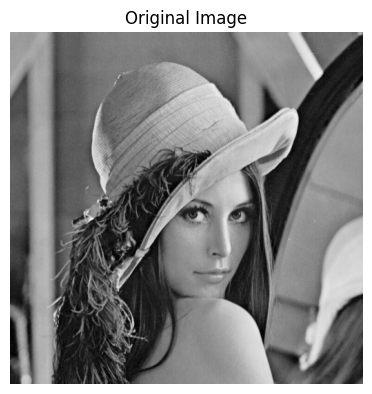

In [172]:
image = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)

# Display the original and filtered images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

img_double =  image.astype(np.float32) / 255.0 




[0.66161    0.66624362 0.67207677 0.67907816 0.6875686  0.69635161
 0.70610917 0.71485888 0.72221639]

 **************** 

[168.71074 169.89256 171.38017 173.16528 175.33058 177.57025 180.05785
 182.28926 184.16528]

 **************** 

[168.7107438  169.89256198 171.38016529 173.16528926 175.33057851
 177.57024793 180.05785124 182.2892562  184.16528926]


(np.float64(-0.5), np.float64(501.5), np.float64(501.5), np.float64(-0.5))

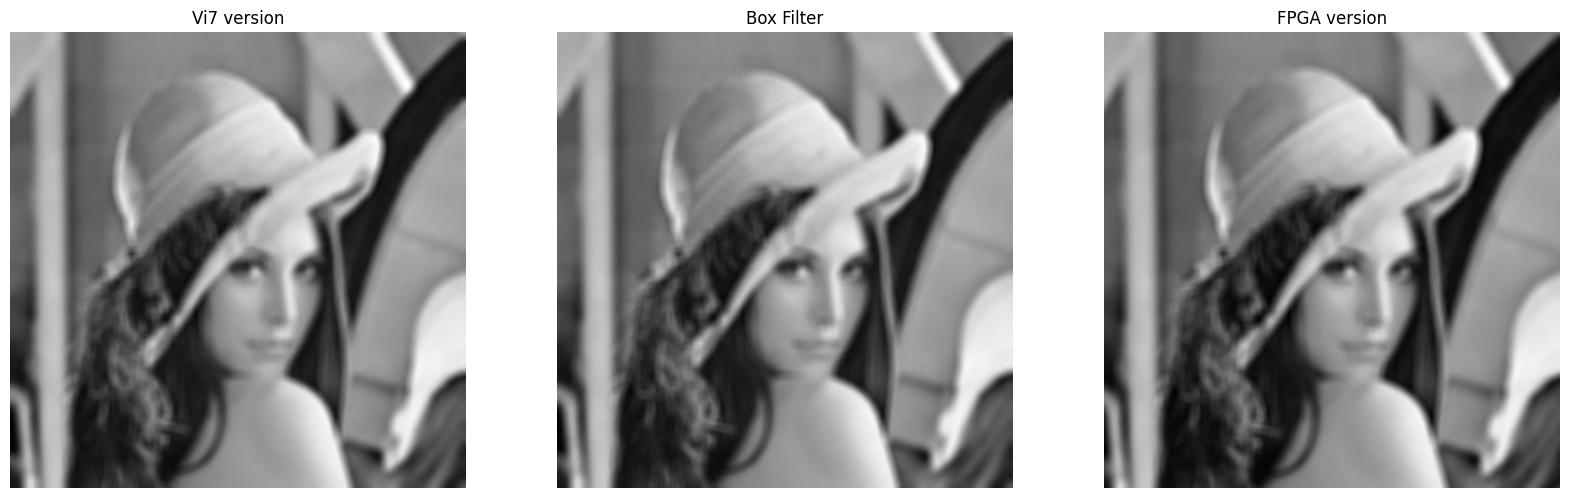

In [178]:
normalizer = np.ones((512,512))
N_vec = boxfilter(normalizer, 5)

boxed_filter = boxfilter(img_double,5)/N_vec
# Display the original and filtered images
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(boxed_filter, cmap='gray')
plt.title("Vi7 version")
plt.axis('off')



boxed_filter_alternative = box_filter_alt(image,11)
boxed_filter_alternative = boxed_filter_alternative / 11**2
plt.subplot(1, 3, 2)
plt.imshow(boxed_filter_alternative, cmap='gray')
plt.title("Box Filter")
plt.axis('off')


print(boxed_filter[172:181,301])
print("\n **************** \n")
print(boxed_filter_alternative[172:181,301])


yeni=compute_window_sums(image,11) / 11**2
print("\n **************** \n")
print(yeni[172-5:181-5,301-5])

plt.subplot(1, 3, 3)
plt.imshow(yeni, cmap='gray')
plt.title("FPGA version")
plt.axis('off')


[91091. 91341. 91626. 92039. 92569. 93135. 93673. 94149. 94603.]

 **************** 



(np.float64(-0.5), np.float64(501.5), np.float64(501.5), np.float64(-0.5))

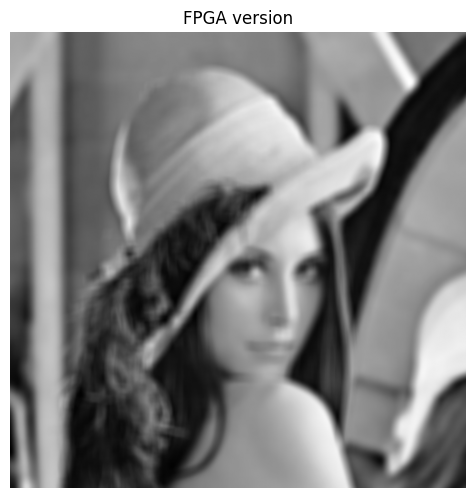

In [174]:
padded_image = zero_pad_image(image, 23)

yeni_padded = compute_window_sums(padded_image,23)
print(yeni_padded[172:181,301])
print("\n **************** \n")
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 3)
plt.imshow(yeni, cmap='gray')
plt.title("FPGA version")
plt.axis('off')

In [197]:
image_keloks = compute_window_sums(image,11)
image_sq = (image.astype(np.int64)) * image
image_kare = compute_window_sums(image_sq,11)
# Save pixel values to text file without decimals
with open("first.txt", "w") as f:
    for row in image_keloks:
        for pixel in row:
            f.write(f"{int(pixel)}\n")  # Convert to int explicitly

print("Pixel data saved to first.txt")


# Save pixel values to text file without decimals
with open("second.txt", "w") as f:
    for row in image_kare:
        for pixel in row:
            f.write(f"{int(pixel)}\n")  # Convert to int explicitly

print("Pixel data saved to second.txt")


Pixel data saved to first.txt
Pixel data saved to second.txt


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

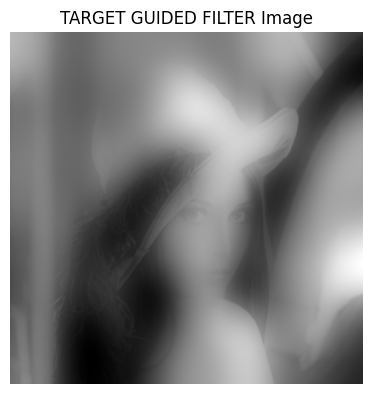

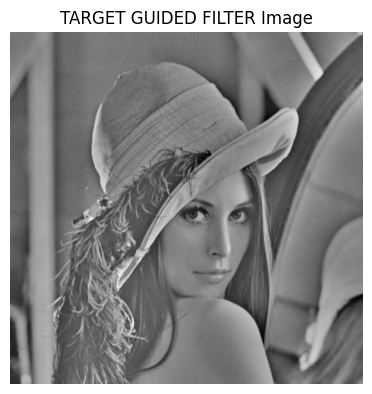

In [179]:
base_layer = fastGF(img_double,31,0.5,1)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(base_layer, cmap='gray')
plt.title("TARGET GUIDED FILTER Image")
plt.axis('off')

detail_layer = img_double - base_layer

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.imshow(detail_layer, cmap='gray')
plt.title("TARGET GUIDED FILTER Image")
plt.axis('off')


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

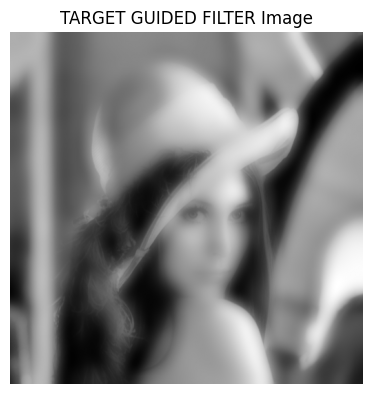

In [186]:
r = 11
window = 2*r+1
(hei, wid) = image.shape
mx = np.ones((hei,wid))
N = boxfilter(mx,r)


############ 
mean_I_org = boxfilter(img_double,r) / N 
mean_II_org = boxfilter(img_double * img_double,r) / N 

cov_Ip_org = mean_II_org - mean_I_org * mean_I_org

eps = 0.25 
regulated_eps = 0.25*255*255
a_org   = cov_Ip_org / (cov_Ip_org + eps)
b_org   = mean_I_org - a_org* mean_II_org

mean_a_org = boxfilter(a_org, r) / N
mean_b_org = boxfilter(b_org, r) / N


q_org = mean_a_org * img_double + mean_b_org


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(q_org, cmap='gray')
plt.title("TARGET GUIDED FILTER Image")
plt.axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

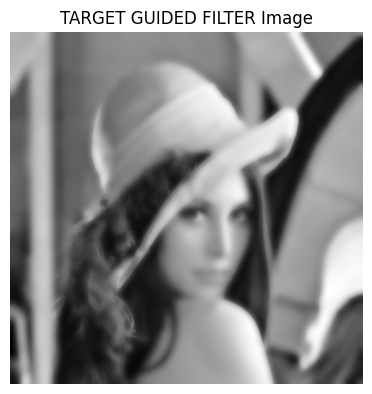

In [196]:

r = 5
window = 2*r+1
(hei, wid) = image.shape
mx = np.ones((hei,wid))
N = boxfilter(mx,11)
##################################################

mean_I = box_filter_alt(image, window)  
image_sq = (image.astype(np.int64)) * image
mean_II = box_filter_alt(image_sq,window) * window**2

mean_sq = mean_I * mean_I
cov_Ip = mean_II - mean_sq


eps = 0.2
regulated_eps = eps* 255 * 255 * window**4
a   = cov_Ip / (cov_Ip + regulated_eps)
##################################################
b   = (mean_I - a* mean_I)

mean_a = box_filter_alt(a, window) 
mean_b = box_filter_alt(b, window) 


q = mean_a * image * window**2 + mean_b

q /= window ** 4

##q = np.clip(q, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(q, cmap='gray')
plt.title("TARGET GUIDED FILTER Image")
plt.axis('off')

In [169]:

##image_sq = (image.astype(np.int64)) * image
##window_size = 11
##hei, wei = image_sq.shape
##yar = np.zeros((hei, wei))
##
### Compute the integral image for the first (window_size - 1) rows
##yar[:window_size-1, :] = compute_integral_image(image_sq[:window_size-1, :])
##
### Compute the integral image for the remaining rows
##for i in range(hei - window_size + 1):
##    temp = compute_integral_image(image_sq[i:, :])
##    yar[i + window_size - 1, :] = temp[window_size - 1, :]
##
### Initialize final result matrix
##final_result = np.zeros((hei - window_size + 1, wei - window_size + 1))
##
### Compute window sums
##for row in range(final_result.shape[0]):
##    for col in range(final_result.shape[1]):
##        if col == 0:
##            final_result[row, col] = yar[row + window_size - 1, window_size - 1]
##        else:
##            final_result[row, col] = (yar[row + window_size - 1, col + window_size - 1] 
##                                      - yar[row + window_size - 1, col - 1])
##
### Normalize and clip results
####normalized_data = final_result / window_size ** 2
##

In [78]:
image_sq = (image.astype(np.int32)) * image

##image_sq = image * image 

image_nor_sq = img_double * img_double


box_image_nor_sq = boxfilter(image_nor_sq,11)/N_vec

box_image_sq = box_filter_alt(image_sq,23) / 23**2 / 256 ** 2



print(box_image_nor_sq[172:181,301])
print("\n **************** \n")
print(box_image_sq[172:181,301])



[0.46312923 0.46598692 0.46921774 0.47369789 0.47924297 0.48509681
 0.49062066 0.49547555 0.50006046]

 **************** 

[0.45951888 0.4623542  0.46556038 0.4700047  0.47550607 0.48131463
 0.4867958  0.49161246 0.4961617 ]


In [118]:
for i in range(20):

    result = cov_Ip[180+i,190]/ cov_Ip_org[180+i,190]
    print(result)

18148430257.584995
18201071344.271805
18170223650.209015
18155670280.290882
18178592558.76156
18176565822.08008
18185366124.166077
18196620300.664383
18205580324.110558
18191404479.58471
18198191652.774796
18197539402.716694
18193373466.847183
18195456054.069202
18188783154.77786
18197834026.99457
18194625624.892296
18195946165.030563
18196099805.50713
18198275763.576485


In [164]:
pixel_data = np.array(image)

# Save pixel values to text file
with open("correct.txt", "w") as f:
    for row in pixel_data:
        for pixel in row:
            f.write(f"{pixel}\n")

print(f"Pixel data saved to")



Pixel data saved to


In [200]:
# Save pixel values to text file without fractional part
with open("b.txt", "w") as f:
    for row in b:
        for pixel in row:
            f.write(f"{int(pixel)}\n")  # Convert to integer (truncates decimal part)

print("Pixel data saved to b.txt")

Pixel data saved to b.txt


In [203]:
a_int = (a * 2**20).astype(np.int32)  # Or np.int64 for larger values
with open("a.txt", "w") as f:
    for row in a_int:
        for pixel in row:
            f.write(f"{int(pixel)}\n")  # Convert to integer (truncates decimal part)

print("Pixel data saved to b.txt")

Pixel data saved to b.txt


In [204]:
mean_a_int = box_filter_alt(a_int, window) 

In [205]:
IISofa = compute_integral_image(a_int)

In [208]:
b_int = b.astype(np.int32)
IISofb = compute_integral_image(b_int)


mean_b_int = box_filter_alt(b_int,window)